This notebook uses a new version of NaMaster (respect to the previous notebooks)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from scipy import stats
import common as co
import flatmaps as fm
import healpy as hp
import numpy as np
import pymaster as nmt
import os

In [3]:
prefix =  'run_sph_2b_same_mask'
run_path = os.path.join('./simulations_outputs/', prefix, prefix)
figures_dir = os.path.join('./simulations_outputs/', prefix, 'figures')
if not os.path.isdir(figures_dir):
    os.makedirs(figures_dir)
fig_run_path = os.path.join(figures_dir, prefix)
data_folder = './data/'
# sims_suffix = '_clsims_0001-0100.npz' Not used in this case
nside=512 # I think it can be read from somewhere
suffix_2b = '_12'

# Common

## Load theoretical data and sampled data

### Load theoretical + check 

In [4]:
f = np.load(os.path.join(data_folder,"cls_lss_2bins.npz"))
lTh = f['ls']
clTh_all = (f['cls'] + f['nls'])[np.triu_indices(f['cls'].shape[0])]
clTh_all_won = (f['cls'])[np.triu_indices(f['cls'].shape[0])]
clTh =  (f['cls'] + f['nls'])[np.ix_([0, 1, 2], [3, 4, 5])].reshape((9, -1))

clTh_T1T1, clTh_T1E1, clTh_E1E1 = clTh_all[[0, 1, 6]]
clTh_T2T2, clTh_T2E2, clTh_E2E2 = clTh_all[[15, 16, 18]]

clTh_T1T2, clTh_T1E2, clTh_T1B2, clTh_E1T2, clTh_E1E2, clTh_E1B2, clTh_B1T2, clTh_B1E2, clTh_B1B2 = clTh

In [5]:
clTh_all.shape

(21, 30000)

Check script: compare th cl's computed with original ones.

In [6]:
f = np.load(run_path + "_cl_th.npz")
lTh_s = f['ls']
clTh_s =  f['cls']

In [7]:
clTh_s.shape

(21, 511)

/usr/lib64/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


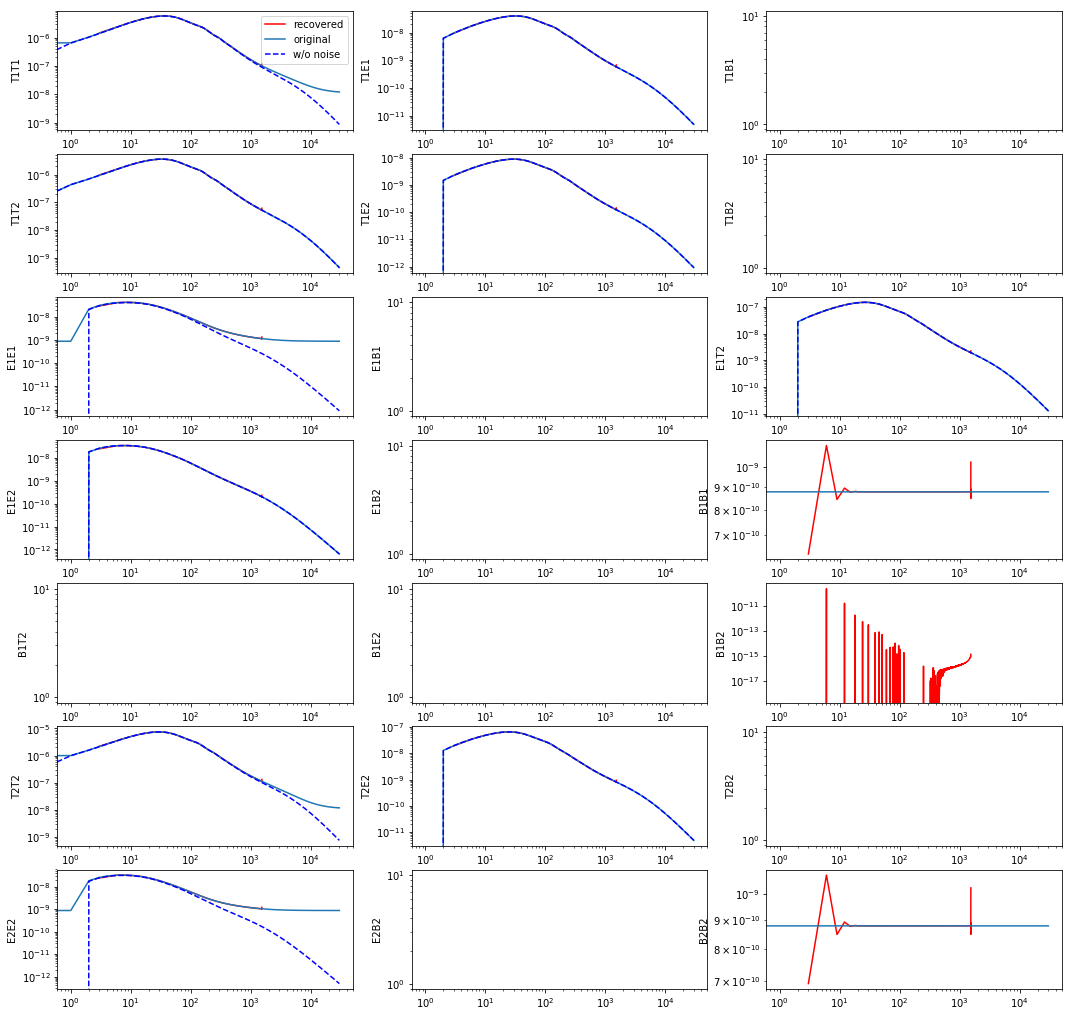

In [8]:
f, axs = plt.subplots(7, 3, figsize=(18, 18))

labels = ["T1T1", "T1E1", "T1B1", "T1T2", "T1E2", "T1B2",
          "E1E1", "E1B1", "E1T2", "E1E2", "E1B2", 
          "B1B1", "B1T2", "B1E2", "B1B2", 
          "T2T2", "T2E2", "T2B2", 
          "E2E2", "E2B2",
          "B2B2"]

for cls, clt, clt_won, ax, lab in zip(clTh_s, clTh_all, clTh_all_won, axs.reshape(-1), labels):
    ax.plot(lTh_s, cls,'r-', label='recovered')
    ax.plot(lTh, clt, label='original')
    ax.plot(lTh,clt_won, 'b--', label='w/o noise')
    ax.set_ylabel(lab)
    ax.loglog()
axs[0,0].legend(loc=0)
plt.show()
plt.close()

In [9]:
#Read mask
#Read mask
fmasks = ["data/mask_lss_sph1.fits", "data/mask_lss_sph1.fits"]

mask_lss_ar = []

for fmask in fmasks:
    mask_lss=hp.ud_grade(hp.read_map(fmask,verbose=False),nside_out=nside)
    mask_lss_ar.append(mask_lss)

#Set up binning scheme
fsky=np.mean(np.product(mask_lss_ar, axis=0))
d_ell=int(1./fsky)
b=nmt.NmtBin(nside,nlb=d_ell)

if not os.path.isfile(run_path + '_ells.txt'):
    np.savetxt(run_path + '_ells.txt', b.get_effective_ells())

### Simulations correlations

In [10]:
if os.path.isfile(run_path + '_cl_0001-20000.npz'):
    cl_ar = np.load(run_path + '_cl_0001-20000.npz')['arr_0']
else:
    from glob import glob
    clfiles = glob(run_path + '_cl_[0-9]*.npz')
    clfiles.sort()

    cl_ar = np.empty((len(clTh_s), len(clfiles), b.get_n_bands()))

    for i, clf in enumerate(clfiles):
        cl = np.load(clf)['cls']
        cl_ar[:, i] = cl
    
    np.savez_compressed(run_path + '_cl_0001-20000.npz', cl_ar)   # Note they are not ordered as numbers!

# clT1T1, clT1E1 = cl_ar[[0, 1]]
# clT2T2, clT2E2 = cl_ar[[15, 16]]
clT1T2, clT1E2, clE1T2, clE1E2 = cl_ar[[3, 4, 8, 9]]
nlbins = b.get_n_bands()
lbins = b.get_effective_ells()
cl_ar_mean = np.mean(cl_ar, axis=1)

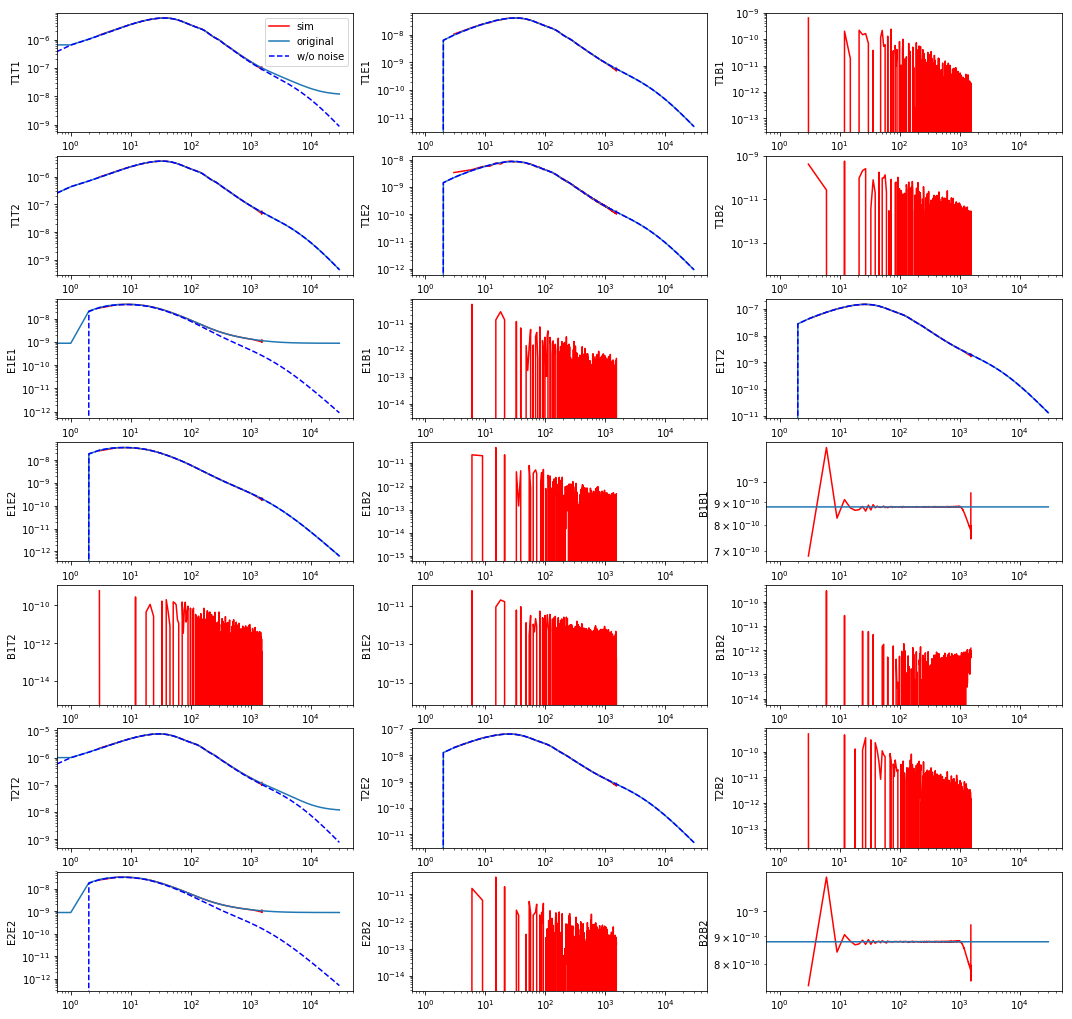

In [11]:
f, axs = plt.subplots(7, 3, figsize=(18, 18))

labels = ["T1T1", "T1E1", "T1B1", "T1T2", "T1E2", "T1B2",
          "E1E1", "E1B1", "E1T2", "E1E2", "E1B2", 
          "B1B1", "B1T2", "B1E2", "B1B2", 
          "T2T2", "T2E2", "T2B2", 
          "E2E2", "E2B2",
          "B2B2"]

for cls, clt, clt_won, ax, lab in zip(cl_ar_mean, clTh_all, clTh_all_won, axs.reshape(-1), labels):
    #ax.plot(lTh_s, cls2,'g-.', label='sim2')
    ax.plot(lTh_s, cls,'r-', label='sim')
    ax.plot(lTh, clt, label='original')
    ax.plot(lTh,clt_won, 'b--', label='w/o noise')
    ax.set_ylabel(lab)
    ax.loglog()
axs[0,0].legend(loc=0)
plt.show()
plt.close()

Healpix has bins of same area but its integrals are not completely exact. Sometimes the best we can do is up to (2 x nbins)

In [12]:
lmax = (b.get_effective_ells() < 2*512).sum()

In [13]:
CovSims_path = run_path + '_cov' + ' _0001-20000.npz' # sims_suffix
if os.path.isfile(CovSims_path):
    C = np.load(CovSims_path)['arr_0']
else:
    C = np.cov(np.concatenate([clT1T2.T, clT1E2.T, clE1T2.T, clE1E2.T]))
    np.savez_compressed(CovSims_path, C)
C = C.reshape((4, nlbins, 4, nlbins))

In [14]:
                                  # --> a1a2b1b2 (a = field 1; b = field 2)
CovSims_T1T2 = C[0, :, 0, :]      # --> 0000
CovSims_T1E2 = C[1, :, 1, :]      # --> 0011
CovSims_E1T2 = C[2, :, 2, :]      # --> 1100
CovSims_E1E2 = C[3, :, 3, :]      # --> 1111

CovSims_T1T2T1E2 = C[0, :, 1, :]  # --> 0001
CovSims_T1T2E1T2 = C[0, :, 2, :]  # --> 0100
CovSims_T1T2E1E2 = C[0, :, 3, :]  # --> 0101

CovSims_T1E2E1T2 = C[1, :, 2, :]  # --> 0110
CovSims_T1E2E1E2 = C[1, :, 3, :]  # --> 0111

CovSims_E1T2E1E2 = C[2, :, 3, :]  # --> 1101


# if os.path.isfile(run_path + '_covTTTEEE'+sims_suffix):
#     CovSims_TTTEEE = np.load(run_path + '_covTTTEEE'+sims_suffix)['arr_0']
# else:
#     CovSims_TTTEEE = np.block([[CovSims_TT, CovSims_TTTE, CovSims_TTEE], 
#                                [CovSims_TTTE.T, CovSims_TE, CovSims_TEEE], 
#                                [CovSims_TTEE.T, CovSims_TEEE.T, CovSims_EE]])
#     np.savez_compressed(run_path + '_covTTTEEE'+sims_suffix, CovSims_TTTEEE)

### Analytic Covariances

In [15]:
w00 = nmt.NmtWorkspace()
w00.read_from(run_path + "_w00{}.dat".format(suffix_2b))
w02 = nmt.NmtWorkspace()
w02.read_from(run_path + "_w02{}.dat".format(suffix_2b))
w22 = nmt.NmtWorkspace()
w22.read_from(run_path + "_w22{}.dat".format(suffix_2b))

We don't need to create a different covariance workspace for each spin combination because it only depends on the masks of the field

In [16]:
def get_fields(mask_ar, w_cont=False) :
    """
    Generate a simulated field.
    It returns two NmtField objects for a spin-0 and a spin-2 field.

    :param mask: a sky mask.
    :param w_cont: deproject any contaminants? (not implemented yet)
    """
    nbins = 2
    spins = [0,2] * nbins
    # maps == [st1, sq1, su1, st2, sq2, su2, ...] (oredered as in spins)
    maps = nmt.synfast_spherical(nside, clTh_all, spins)
    st1, sq1, su1, st2, sq2, su2 = maps

    if w_cont :
        raise ValueError('Contaminants not implemented yet')
    else :
        ff0_1=nmt.NmtField(mask_ar[0], [st1])
        ff0_2=nmt.NmtField(mask_ar[1], [st2])
        ff2_1=nmt.NmtField(mask_ar[0], [sq1, su1])
        ff2_2=nmt.NmtField(mask_ar[1], [sq2, su2])

    return (ff0_1,ff2_1), (ff0_2, ff2_2)

np.random.seed(1000)
fields = get_fields(mask_lss_ar) #, o.nss_cont or o.nls_cont)
fbin1,  fbin2 = fields

cw = nmt.NmtCovarianceWorkspace()

if os.path.isfile(run_path + '_cw{}.dat'.format(suffix_2b)):
    cw.read_from(run_path + '_cw{}.dat'.format(suffix_2b))
else: 
    cw.compute_coupling_coefficients(fbin1[0], fbin2[0])
    cw.write_to(run_path + '_cw{}.dat'.format(suffix_2b))

#### Approx Efstathiou

In [17]:
clt1t2 = clt2t1 = clTh_T1T2
clt1e2 = cle2t1 = clTh_T1E2
cle1t2 = clt2e1 = clTh_E1T2
cle1e2 = cle2e1 = clTh_E1E2
clb1b2 = clb2b1 = clTh_B1B2

clt1t1 = clTh_T1T1
clt1e1 = cle1t1 = clTh_T1E1
cle1e1 = clTh_E1E1

clt2t2 = clTh_T2T2
clt2e2 = cle2t2 = clTh_T2E2
cle2e2 = clTh_E2E2

clb1b1 = clb2b2 = 0 * cle2e2

# nmt.gcf(spin_a1, spin_a2, spin_b1, spin_b2, larr, cla1b1, cla1b2, cla2b1, cla2b2, wa, wb=None)

if os.path.isfile(run_path+'_c0000{}.npz'.format(suffix_2b)):
    c0000 = np.load(run_path+'_c0000{}.npz'.format(suffix_2b))['arr_0']
else:
    c0000=nmt.gaussian_covariance(cw,0,0,0,0,[clt1t1],[clt1t2],[clt1t2],[clt2t2],w00); print(c0000.shape)
    np.savez_compressed(run_path+'_c0000{}.npz'.format(suffix_2b), c0000)
    
if os.path.isfile(run_path+'_c0002{}.npz'.format(suffix_2b)):
    c0002 = np.load(run_path+'_c0002{}.npz'.format(suffix_2b))['arr_0']
else:
    c0002=nmt.gaussian_covariance(cw,0,0,0,2,[clt1t1],[clt1e2,0*clt1e2],[clt2t1],
                                       [clt2e2,0*clt1e2],w00,w02).reshape((nlbins, 1, nlbins, 2)); print(c0002.shape)
    np.savez_compressed(run_path+'_c0002{}.npz'.format(suffix_2b), c0002)
    
if os.path.isfile(run_path+'_c0022{}.npz'.format(suffix_2b)):
    c0022 = np.load(run_path+'_c0022{}.npz'.format(suffix_2b))['arr_0']
else:
    c0022=nmt.gaussian_covariance(cw,0,0,2,2,[clt1e1,0*clt1e2],[clt1e2,0*clt1e2],
                                       [clt2e1,0*clt1e2],[clt2e2,0*clt1e2],w00,w22).reshape((nlbins, 1, nlbins, 4)); print(c0022.shape)
    np.savez_compressed(run_path+'_c0022{}.npz'.format(suffix_2b), c0022)
    
if os.path.isfile(run_path+'_c0202{}.npz'.format(suffix_2b)):
    c0202 = np.load(run_path+'_c0202{}.npz'.format(suffix_2b))['arr_0']
else:
    c0202=nmt.gaussian_covariance(cw,0,2,0,2,[clt1t1],[clt1e2,0*clt1e2],[cle2t1,0*clt1e2],
                                       [cle2e2,0*cle1e2,0*clb1b2,clb2b2],w02,w02).reshape((nlbins, 2, nlbins, 2)); print(c0202.shape)
    np.savez_compressed(run_path+'_c0202{}.npz'.format(suffix_2b), c0202)
    
if os.path.isfile(run_path+'_c0222{}.npz'.format(suffix_2b)):
    c0222 = np.load(run_path+'_c0222{}.npz'.format(suffix_2b))['arr_0']
else:
    c0222=nmt.gaussian_covariance(cw,0,2,2,2,[clt1e1,0*clt1e2],[clt1e2,0*clt1e2],
                                       [cle2e1,0*cle1e2,0*clb1b2,clb2b1],
                                       [cle2e2,0*cle1e2,0*clb1b2,clb2b2],w02,w22).reshape((nlbins, 2, nlbins, 4)); print(c0222.shape)
    np.savez_compressed(run_path+'_c0222{}.npz'.format(suffix_2b), c0222)
    
if os.path.isfile(run_path+'_c2222{}.npz'.format(suffix_2b)):
    c2222 = np.load(run_path+'_c2222{}.npz'.format(suffix_2b))['arr_0']
else:
    c2222=nmt.gaussian_covariance(cw,2,2,2,2,[cle1e1,0*cle1e2,0*clb1b2,clb1b1],
                                       [cle1e2,0*cle1e2,0*clb1b2,clb1b2],[cle2e1,0*cle1e2,0*clb1b2,clb2b1],
                                       [cle2e2,0*cle1e2,0*clb1b2,clb2b2],w22,w22).reshape((nlbins, 4, nlbins, 4)); print(c2222.shape)
    np.savez_compressed(run_path+'_c2222{}.npz'.format(suffix_2b), c2222)
    
if os.path.isfile(run_path+'_c2020{}.npz'.format(suffix_2b)):
    c2020 = np.load(run_path+'_c2020{}.npz'.format(suffix_2b))['arr_0']
else:
    c2020=nmt.gaussian_covariance(cw,2,0,2,0,[cle1e1,0*cle1e2,0*clb1b2,clb1b1],[cle1t2,0*clt1e2],
                                       [clt2e1,0*clt1e2],[clt2t2],w02,w02).reshape((nlbins, 2, nlbins, 2)); print(c2020.shape)
    np.savez_compressed(run_path+'_c2020{}.npz'.format(suffix_2b), c2020)

if os.path.isfile(run_path+'_c0020{}.npz'.format(suffix_2b)):  
    c0020 = np.load(run_path+'_c0020{}.npz'.format(suffix_2b))['arr_0']
else:
    c0020=nmt.gaussian_covariance(cw,0,0,2,0,[clt1e1,0*clt1e2],[clt1t2],
                                       [clt2e1,0*clt1e2],[clt2t2],w00,w02).reshape((nlbins, 1, nlbins, 2)); print(c0020.shape)
    np.savez_compressed(run_path+'_c0020{}.npz'.format(suffix_2b), c0020)
    
if os.path.isfile(run_path+'_c0220{}.npz'.format(suffix_2b)):  
    c0220 = np.load(run_path+'_c0220{}.npz'.format(suffix_2b))['arr_0']
else:
    c0220=nmt.gaussian_covariance(cw,0,2,2,0,[clt1e1,0*clt1e2],[clt1t2],
                                       [cle2e1,0*cle1e2,0*clb1b2,clb2b1],
                                       [cle2t2,0*clt1e2],w02,w02).reshape((nlbins, 2, nlbins, 2)); print(c0220.shape)
    np.savez_compressed(run_path+'_c0220{}.npz'.format(suffix_2b), c0220)
    
if os.path.isfile(run_path+'_c2022{}.npz'.format(suffix_2b)):  
    c2022 = np.load(run_path+'_c2022{}.npz'.format(suffix_2b))['arr_0']
else:
    c2022=nmt.gaussian_covariance(cw,2,0,2,2,[cle1e1,0*cle1e2,0*clb1b2,clb1b1],
                                       [cle1e2,0*cle1e2,0*clb1b2,clb1b2],[clt2e1,0*clt1e2],
                                       [clt2e2,0*clt1e2],w02,w22).reshape((nlbins,2,nlbins,4)); print(c2022.shape)

    np.savez_compressed(run_path+'_c2022{}.npz'.format(suffix_2b), c2022)
    
#c0200=nmt.gaussisloan_covariance(cw,0,2,0,0,[cltt],[cltt],[clte,0*clt1e2],[clte,0*clt1e2],w02,w00); print(c0200.shape)
#c0220=nmt.gaussian_covariance(cw,0,2,2,0,[clte,0*clt1e2],[cltt],[clee,0*cle1e2,0*clb1b2,clbb],[clte,0*clt1e2],w02,w02); print(c0220.shape)
#c2000=nmt.gaussian_covariance(cw,2,0,0,0,[clte,0*clt1e2],[clte,0*clt1e2],[cltt],[cltt],w02,w00); print(c2000.shape)
#c2002=nmt.gaussian_covariance(cw,2,0,0,2,[clte,0*clt1e2],[clee,0*cle1e2,0*clb1b2,clbb],[cltt],[clte,0*clt1e2],w02,w02); print(c2002.shape)
#c2200=nmt.gaussian_covariance(cw,2,2,0,0,[clte,0*clt1e2],[clte,0*clt1e2],[clte,0*clt1e2],[clte,0*clt1e2],w22,w00); print(c2200.shape)
#c2202=nmt.gaussian_covariance(cw,2,2,0,2,[clte,0*clt1e2],[clee,0*cle1e2,0*clb1b2,clbb],[clte,0*clt1e2],[clee,0*cle1e2,0*clb1b2,clbb],w22,w02); print(c2202.shape)
#c2220=nmt.gaussian_covariance(cw,2,2,2,0,[clee,0*cle1e2,0*clb1b2,clbb],[clte,0*clt1e2],[clee,0*cle1e2,0*clb1b2,clbb],[clte,0*clt1e2],w22,w02); print(c2220.shape)

# CovTh_TT = c0000
# CovTh_TTTE, CovTh_TTTB = c0002[:, 0, :, [0, 1]]
# CovTh_TTEE, CovTh_TTEB, CovTh_TTBE, CovTh_TTBB = c0022[:, 0, :, [0, 1, 2, 3]]
# CovTh_TETE, CovTh_TETB = c0202[:, 0, :, [0, 1] ]
# CovTh_TBTE, CovTh_TBTB = c0202[:, 1, :, [0, 1] ]
# CovTh_TEEE, CovTh_TEEB, CovTh_TEBE, CovTh_TEBB =  c0222[:, 0, :, [0, 1, 2, 3] ]
# CovTh_TBEE, CovTh_TBEB, CovTh_TBBE, CovTh_TBBB = c0222[:, 1, :, [0, 1, 2, 3] ]
# CovTh_EEEE, CovTh_EEEB, CovTh_EEBE, CovTh_EEBB = c2222[:, 0, :, [0, 1, 2, 3] ]
# CovTh_EBEE, CovTh_EBEB, CovTh_EBBE, CovTh_EBBB = c2222[:, 1, :, [0, 1, 2, 3] ]
# CovTh_BEEE, CovTh_BEEB, CovTh_BEBE, CovTh_BEBB = c2222[:, 2, :, [0, 1, 2, 3] ]
# CovTh_BBEE, CovTh_BBEB, CovTh_BBBE, CovTh_BBBB = c2222[:, 3, :, [0, 1, 2, 3] ]

CovTh_T1T2 = c0000
CovTh_T1E2 = c0202[:, 0, :, 0 ]
CovTh_E1T2 = c2020[:,0,:,0]
CovTh_E1E2 = c2222[:, 0, :, 0 ]

CovTh_T1T2T1E2 = c0002[:, 0, :, 0 ]
CovTh_T1T2E1T2 = c0020[:,0,:,0]
CovTh_T1T2E1E2 = c0022[:, 0, :, 0]

CovTh_T1E2E1T2 = c0220[:,0,:,0]
CovTh_T1E2E1E2 = c0222[:,0,:,0]

CovTh_E1T2E1E2 = c2022[:,0,:,0]



# if os.path.isfile(run_path + '_covThTTTEEE.npz'):
#     CovTh_TTTEEE = np.load(run_path + '_covThTTTEEE.npz')['arr_0']
# else:
#     CovTh_TTTEEE = np.block([[CovTh_TT, CovTh_TTTE, CovTh_TTEE], 
#                                [CovTh_TTTE.T, CovTh_TE, CovTh_TEEE], 
#                                [CovTh_TTEE.T, CovTh_TEEE.T, CovTh_EE]])
#     np.savez_compressed(run_path + '_covThTTTEEE.npz', CovTh_TTTEEE)

#### Spin 2 ~ Spin 0

In [18]:
# nmt.gcf(spin_a1, spin_a2, spin_b1, spin_b2, larr, cla1b1, cla1b2, cla2b1, cla2b2, wa, wb=None)


CovTh0_T1T2 = CovTh_T1T2
CovTh0_T1E2 = nmt.gaussian_covariance(cw,0,0,0,0,[clt1t1],[clt1e2],[cle2t1],[cle2e2],w00)
CovTh0_E1T2 = nmt.gaussian_covariance(cw,0,0,0,0,[cle1e1],[cle1t2],[clt2e1],[clt2t2],w00)
# CovTh0_T1B2 = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltb],[cltb],[clbb],w00)
CovTh0_E1E2 = nmt.gaussian_covariance(cw,0,0,0,0,[cle1e1],[cle1e2],[cle2e1],[cle2e2],w00)
# CovTh0_E1B2 = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clee],[cleb],[cleb],[clbb],w00)
# CovTh0_B1B2 = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clbb],[clbb],[clbb],[clbb],w00)

# CovTh0_TTTE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[clte],[cltt],[clte],w00)
# CovTh0_TTTB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltb],[cltt],[cltb],w00)
# CovTh0_TTEE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[clte],[clte],[clte],w00)
# CovTh0_TTEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[cltb],[clte],[cltb],w00)
# CovTh0_TTBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltb],[cltb],[cltb],[cltb],w00)

# CovTh0_TETB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltb],[clte],[cleb],w00)
# CovTh0_TEEE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[clte],[clee],[clee],w00)
# CovTh0_TEEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[cltb],[clee],[cleb],w00)
# CovTh0_TEBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltb],[cltb],[cleb],[cleb],w00)

# CovTh0_TBEE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[clte],[clbe],[clbe],w00)
# CovTh0_TBEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[cltb],[clbe],[clbb],w00)
# CovTh0_TBBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltb],[cltb],[clbb],[clbb],w00)

# CovTh0_EEEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clee],[cleb],[clee],[cleb],w00)
# CovTh0_EEBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cleb],[cleb],[cleb],[cleb],w00)

# CovTh0_EBBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cleb],[clbb],[cleb],[clbb],w00)

#### Naive approx

In [19]:
l0=b.get_effective_ells()-d_ell/2
lf=b.get_effective_ells()+d_ell/2
l_bpw=np.array([l0, lf])

CovThN_T1T2 = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clt1t1, clt1t2,clt2t1,clt2t2)
CovThN_T1E2 = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clt1t1, clt1e2,cle2t1,cle2e2)
CovThN_E1T2 = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cle1e1, cle1t2, clt2e1, clt2t2)
# CovThN_TB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_TT, clTh_TB, clTh_TB, clTh_BB)
CovThN_E1E2 = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cle1e1, cle1e2, cle2e1, cle2e2)
# CovThN_EB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_EE, clTh_EB, clTh_EB, clTh_BB)
# CovThN_BB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_BB, clTh_BB, clTh_BB, clTh_BB)

# CovThN_TTTE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltt, clte, cltt, clte)
# CovThN_TTTB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltt, cltb, cltt, cltb)
# CovThN_TTEE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, clte, clte, clte)
# CovThN_TTEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, cltb, clte, cltb)
# CovThN_TTBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltb, cltb, cltb, cltb)

# CovThN_TETB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltt, cltb, clte, cleb)
# CovThN_TEEE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, clte, clee, clee)
# CovThN_TEEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, cltb, clee, cleb)
# CovThN_TEBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltb, cltb, cleb, cleb)

# CovThN_TBEE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, clte, clbe, clbe)
# CovThN_TBEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, cltb, clbe, clbb)
# CovThN_TBBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltb, cltb, clbb, clbb)

# CovThN_EEEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clee, cleb, clee, cleb)
# CovThN_EEBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cleb, cleb, cleb, cleb)

# CovThN_EBBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cleb, clbb, cleb, clbb)

# Efstathiou approximation

In [20]:
foutput = fig_run_path + '_Efstathiou'

## T1T2T1T2

Checks for TTTT
Diagonal covariance matrix


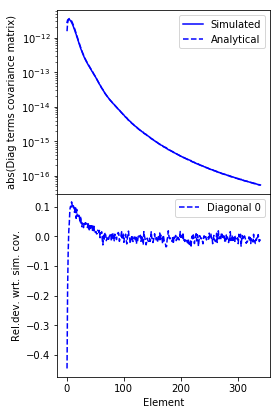

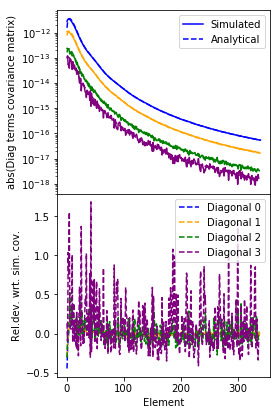

Chi2 distribution check


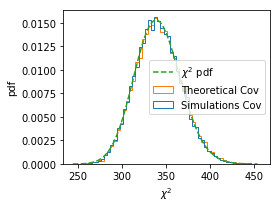

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.010850000000000026, pvalue=0.1886521421465089)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004877747072081939, pvalue=0.7281126334038731)
KS between th. and chi2 distributions:  KstestResult(statistic=0.009872187099770557, pvalue=0.04054818421100138)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006926402950932942, pvalue=0.2925790245271948)

Difference between analytic and sims. correlation matrix


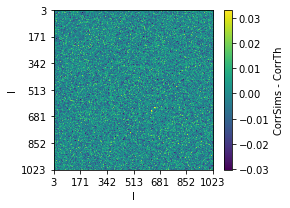

Eigenvalues vs l


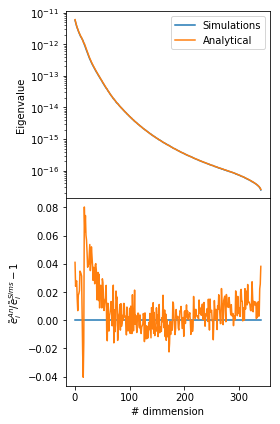

Row of cov. matrix.


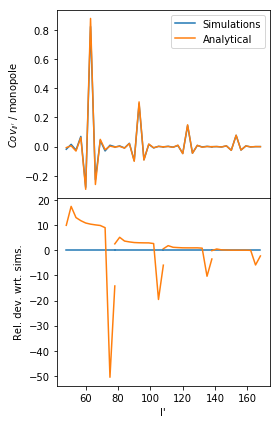

In [21]:
chi2_T1T2T1T2, corr_T1T2T1T2 = co.do_all_checks(lbins[:lmax], clT1T2[:, :lmax], CovSims_T1T2[:lmax, :lmax], CovTh_T1T2[:lmax, :lmax], 
                                                modes="TTTT", foutput=foutput + '_T1T2T1T2')

## T1E2T1E2

Checks for TETE
Diagonal covariance matrix


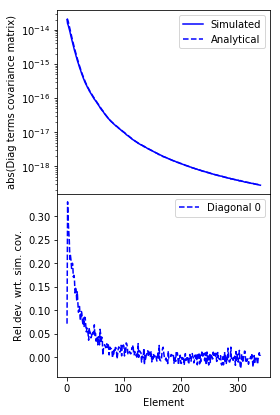

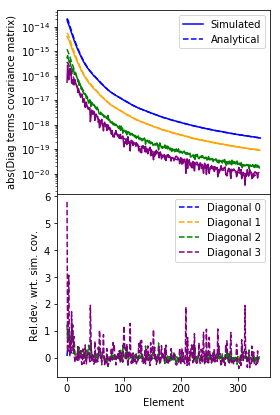

Chi2 distribution check


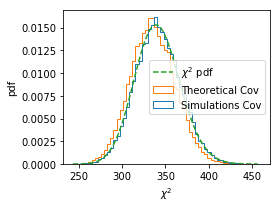

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.09370000000000006, pvalue=7.191168281333783e-77)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0036550490059193974, pvalue=0.9520940422206667)
KS between th. and chi2 distributions:  KstestResult(statistic=0.09291684597156169, pvalue=2.094469957011333e-150)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.00424415399144909, pvalue=0.8639992718309415)

Difference between analytic and sims. correlation matrix


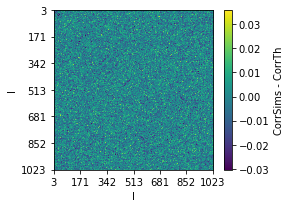

Eigenvalues vs l


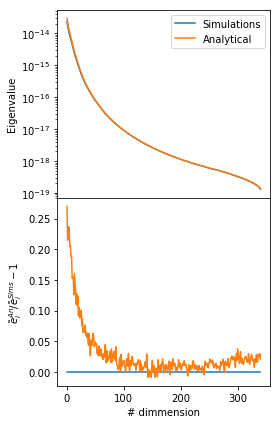

Row of cov. matrix.


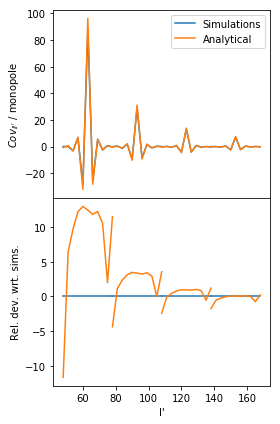

In [22]:
chi2_T1E2T1E2, corr_T1E2T1E2 = co.do_all_checks(lbins[:lmax], clT1E2[:, :lmax], CovSims_T1E2[:lmax, :lmax], CovTh_T1E2[:lmax, :lmax],
                                                modes="TETE", foutput=foutput + '_T1E2T1E2')

## E1E2E1E2

Checks for EEEE
Diagonal covariance matrix


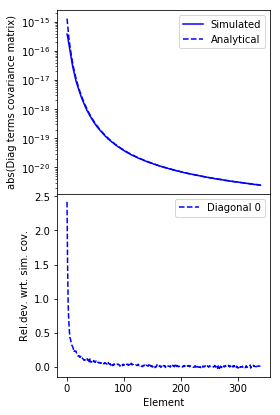

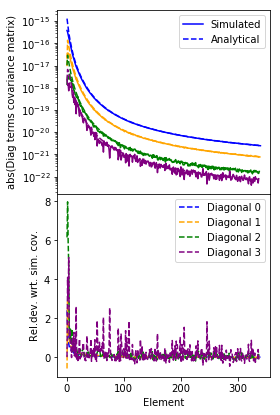

Chi2 distribution check


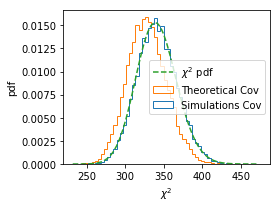

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.2007, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.006067728473215794, pvalue=0.4530880137680063)
KS between th. and chi2 distributions:  KstestResult(statistic=0.20287852102517373, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005624150450650234, pvalue=0.5516854657575407)

Difference between analytic and sims. correlation matrix


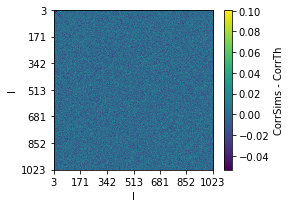

Eigenvalues vs l


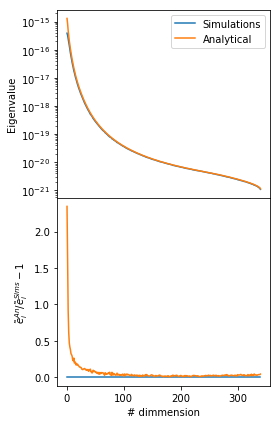

Row of cov. matrix.


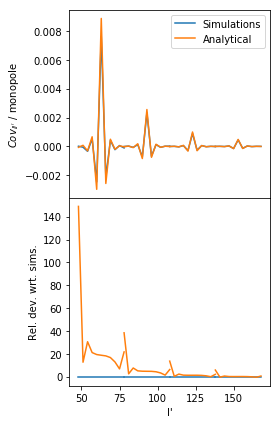

In [23]:
chi2_E1E2E1E2, corr_E1E2E1E2 = co.do_all_checks(lbins[:lmax], clE1E2[:, :lmax], CovSims_E1E2[:lmax, :lmax], CovTh_E1E2[:lmax, :lmax],
                                                modes="EEEE", foutput=foutput + '_E1E2E1E2')

## E1T2

Checks for E1T2
Diagonal covariance matrix


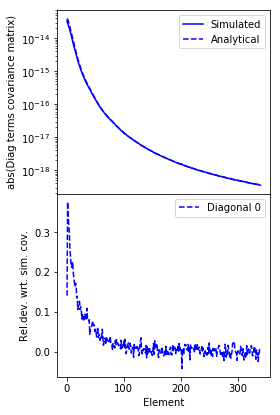

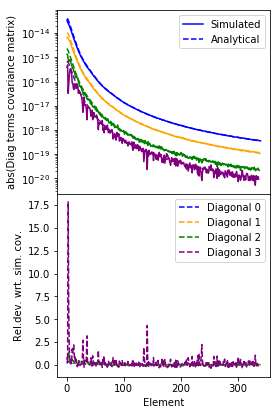

Chi2 distribution check


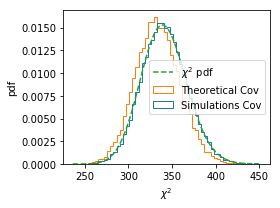

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.12009999999999998, pvalue=5.15283367307992e-126)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004040625327597067, pvalue=0.8997039565499346)
KS between th. and chi2 distributions:  KstestResult(statistic=0.11704825960836651, pvalue=2.006909986916629e-238)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0066915040244230894, pvalue=0.33202282403982)

Difference between analytic and sims. correlation matrix


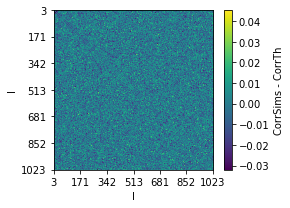

Eigenvalues vs l


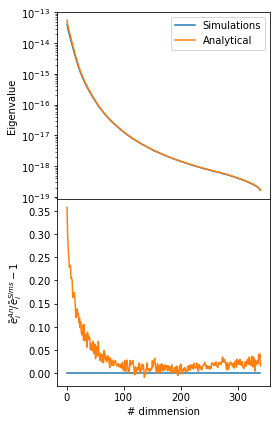

Row of cov. matrix.


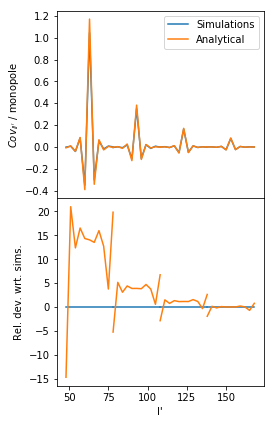

In [24]:
chi2_E1T2E1T2, corr_E1T2E1T2 = co.do_all_checks(lbins[:lmax], clE1T2[:, :lmax], CovSims_E1T2[:lmax, :lmax], CovTh_E1T2[:lmax, :lmax],
                                                modes="E1T2", foutput=foutput + '_E1T2E1T2')

# Spin0 approximation

In [25]:
foutput = fig_run_path + '_spin0app'

## TTTT

Checks for TTTT
Diagonal covariance matrix


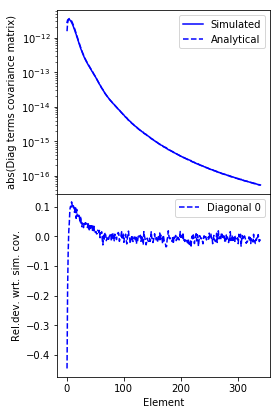

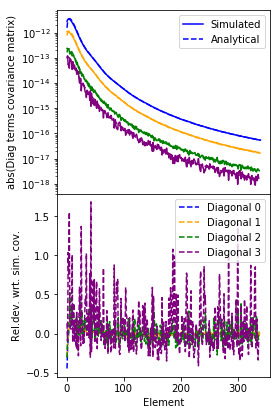

Chi2 distribution check


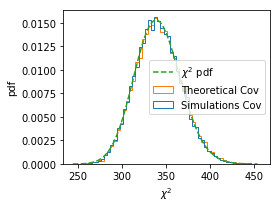

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.010850000000000026, pvalue=0.1886521421465089)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004877747072081939, pvalue=0.7281126334038731)
KS between th. and chi2 distributions:  KstestResult(statistic=0.009872187099770557, pvalue=0.04054818421100138)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.007336018412921086, pvalue=0.23197898409927115)

Difference between analytic and sims. correlation matrix


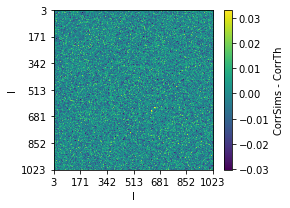

Eigenvalues vs l


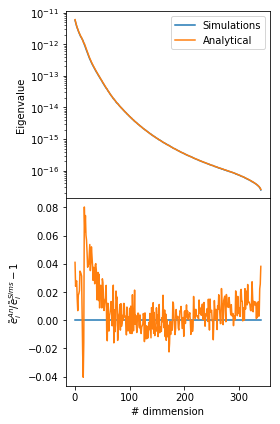

Row of cov. matrix.


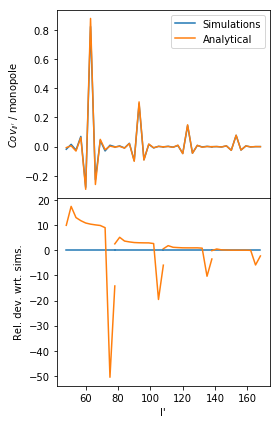

In [26]:
chi20_T1T2T1T2, corr0_T1T2T1T2 = co.do_all_checks(lbins[:lmax], clT1T2[:, :lmax], CovSims_T1T2[:lmax, :lmax], CovTh0_T1T2[:lmax, :lmax],
                                                  modes="TTTT", foutput=foutput + '_T1T2T1T2')

## TETE

Checks for TETE
Diagonal covariance matrix


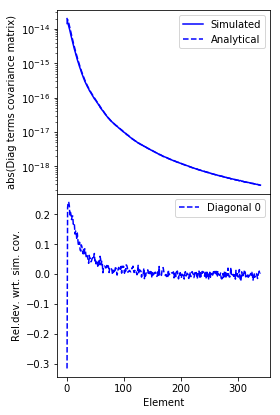

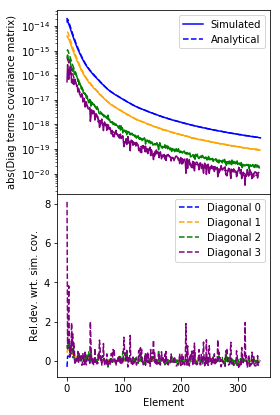

Chi2 distribution check


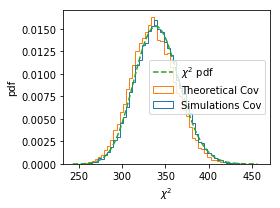

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.07764999999999994, pvalue=6.343687290280616e-53)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0036550490059193974, pvalue=0.9520940422206667)
KS between th. and chi2 distributions:  KstestResult(statistic=0.07725825399315722, pvalue=4.08975247675653e-104)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.007874127531947744, pvalue=0.16737549501584836)

Difference between analytic and sims. correlation matrix


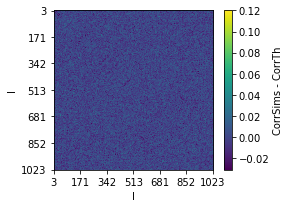

Eigenvalues vs l


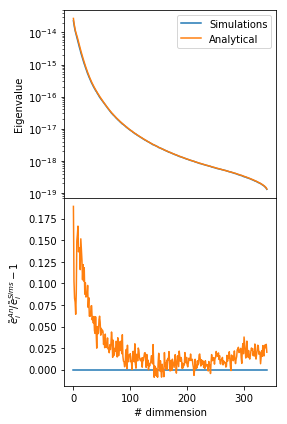

Row of cov. matrix.


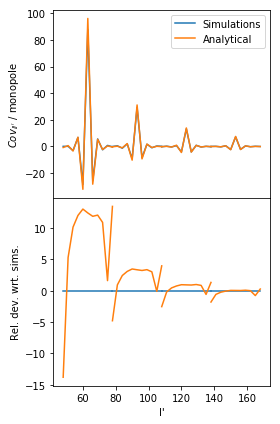

In [27]:
chi20_T1E2T1E2, corr0_T1E2T1E2 = co.do_all_checks(lbins[:lmax], clT1E2[:, :lmax], CovSims_T1E2[:lmax, :lmax], CovTh0_T1E2[:lmax, :lmax],
                                                  modes="TETE", foutput=foutput + '_T1E2T1E2')

## EEEE

Checks for EEEE
Diagonal covariance matrix


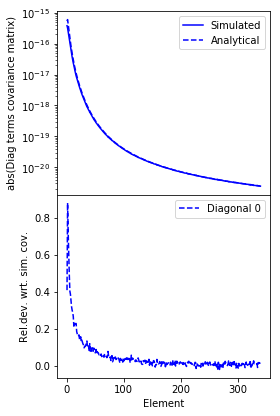

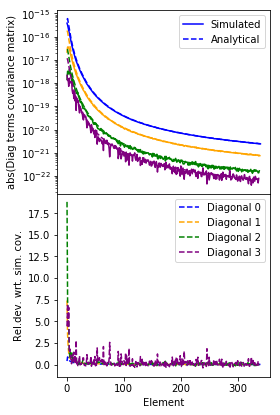

Chi2 distribution check


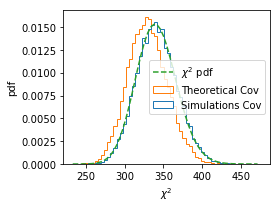

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.18280000000000007, pvalue=2.2455845178521898e-291)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.006067728473215794, pvalue=0.4530880137680063)
KS between th. and chi2 distributions:  KstestResult(statistic=0.18530944023801837, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006325585016765056, pvalue=0.4002676152168461)

Difference between analytic and sims. correlation matrix


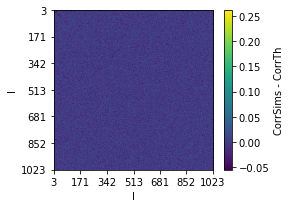

Eigenvalues vs l


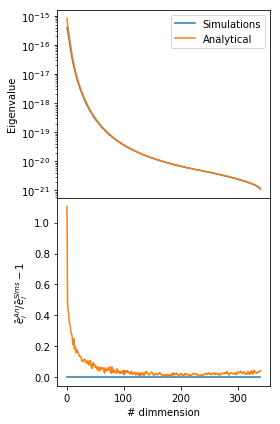

Row of cov. matrix.


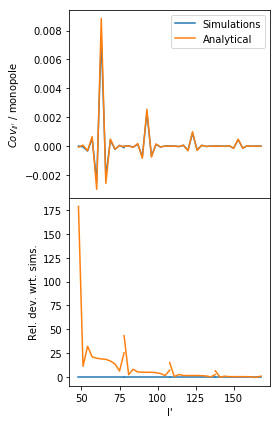

In [28]:
chi20_E1E2E1E2, corr0_E1E2E1E2 = co.do_all_checks(lbins[:lmax], clE1E2[:, :lmax], CovSims_E1E2[:lmax, :lmax], CovTh0_E1E2[:lmax, :lmax],
                                                  modes="EEEE", foutput=foutput + '_E1E2E1E2')

## E1T2E1T2

Checks for EEEE
Diagonal covariance matrix


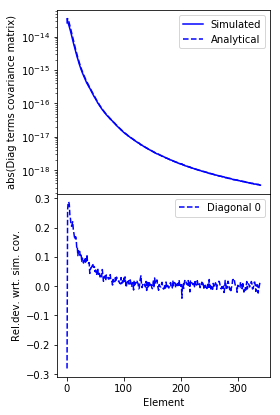

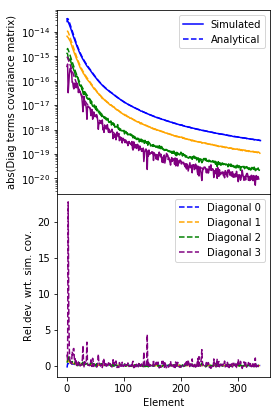

Chi2 distribution check


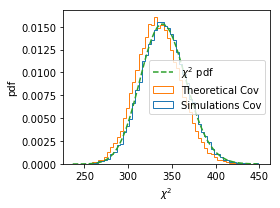

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.10345000000000004, pvalue=1.3188983180885971e-93)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004040625327597067, pvalue=0.8997039565499346)
KS between th. and chi2 distributions:  KstestResult(statistic=0.10121790823968252, pvalue=2.118473531083923e-178)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006386717199831138, pvalue=0.38830260107855397)

Difference between analytic and sims. correlation matrix


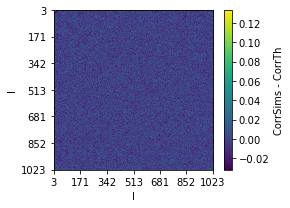

Eigenvalues vs l


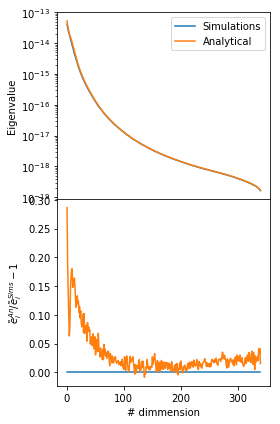

Row of cov. matrix.


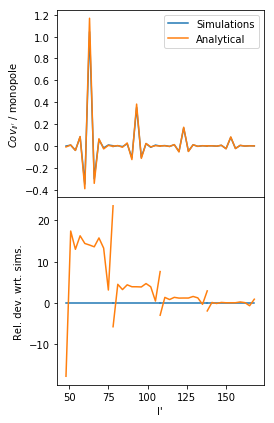

In [29]:
chi20_E1T2E1T2, corr0_E1T2E1T2 = co.do_all_checks(lbins[:lmax], clE1T2[:, :lmax], CovSims_E1T2[:lmax, :lmax], CovTh0_E1T2[:lmax, :lmax],
                                                  modes="EEEE", foutput=foutput + '_E1T2E1T2')

# Naive approximation

In [30]:
foutput = fig_run_path + '_naive'

## TTTT

Checks for TTTT
Diagonal covariance matrix


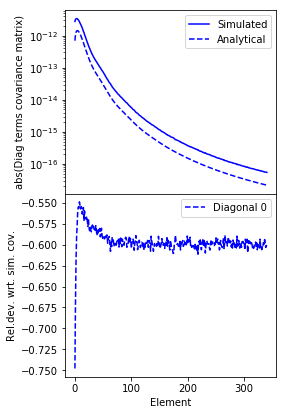

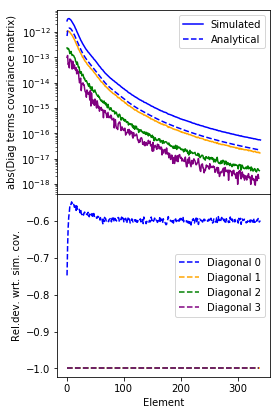

Chi2 distribution check


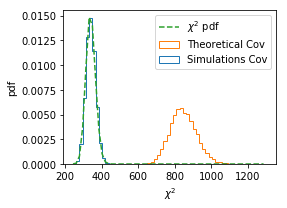

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004877747072081939, pvalue=0.7281126334038731)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9999999999999789, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005620818056851662, pvalue=0.552456057577025)

Difference between analytic and sims. correlation matrix


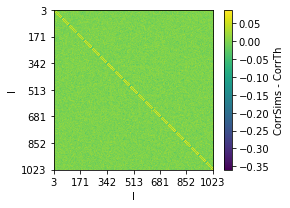

Eigenvalues vs l


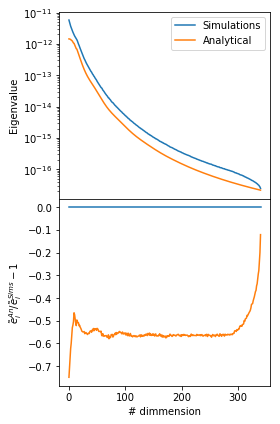

Row of cov. matrix.


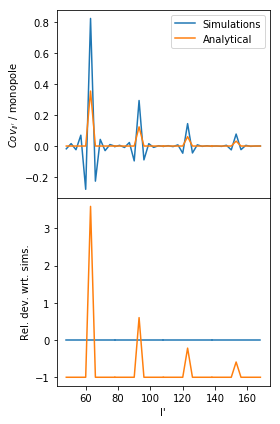

In [31]:
chi2N_T1T2T1T2, corr2N_T1T2T1T2 = co.do_all_checks(lbins[:lmax], clT1T2[:, :lmax], CovSims_T1T2[:lmax, :lmax], CovThN_T1T2[:lmax, :lmax],
                                                   modes="TTTT", foutput=foutput + '_T1T2T1T2')

## TETE

Checks for TETE
Diagonal covariance matrix


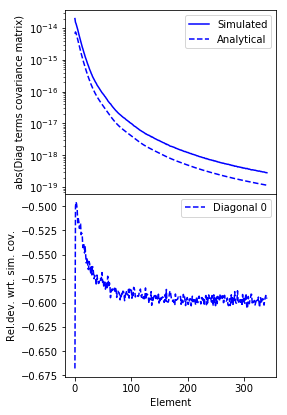

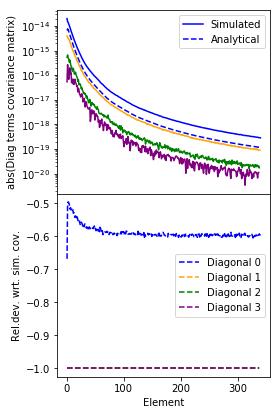

Chi2 distribution check


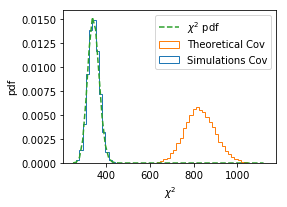

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0036550490059193974, pvalue=0.9520940422206667)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9999999999999761, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005697229870213927, pvalue=0.5348807868481191)

Difference between analytic and sims. correlation matrix


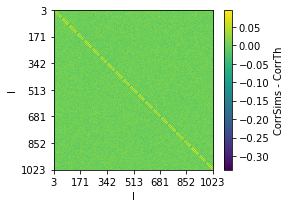

Eigenvalues vs l


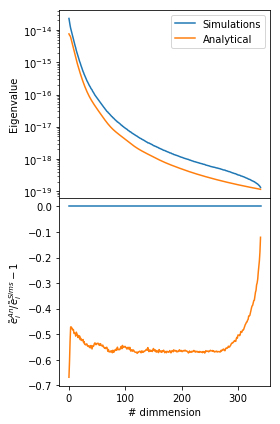

Row of cov. matrix.


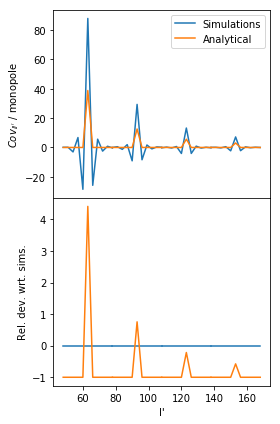

In [32]:
chi2N_T1E2T1E2, corrN_T1E2T1E2 = co.do_all_checks(lbins[:lmax], clT1E2[:, :lmax], CovSims_T1E2[:lmax, :lmax], CovThN_T1E2[:lmax, :lmax],
                                                  modes="TETE", foutput=foutput + '_T1E2T1E2')

## EEEE

Checks for EEEE
Diagonal covariance matrix


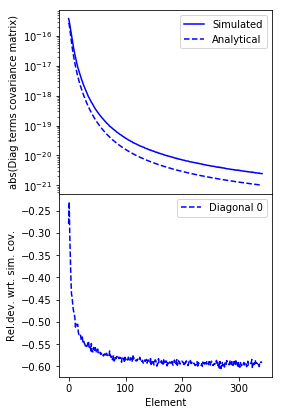

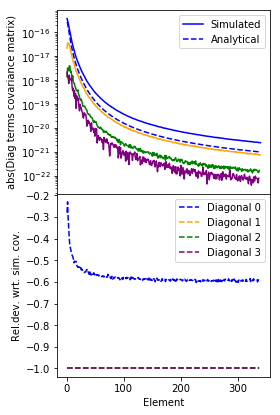

Chi2 distribution check


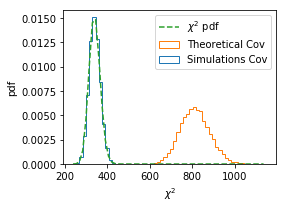

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.006067728473215794, pvalue=0.4530880137680063)
KS between th. and chi2 distributions:  KstestResult(statistic=0.999999999999951, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.003714872984771689, pvalue=0.9453733199589414)

Difference between analytic and sims. correlation matrix


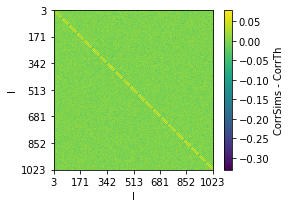

Eigenvalues vs l


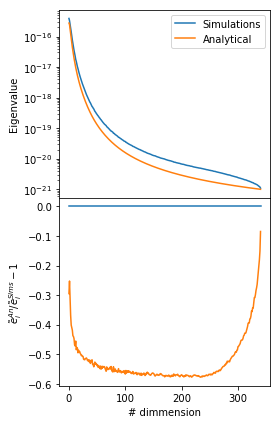

Row of cov. matrix.


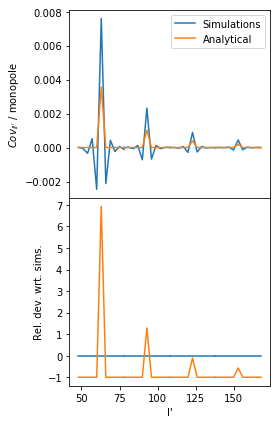

In [33]:
chi2N_E1E2E1E2, corrN_E1E2E1E2 = co.do_all_checks(lbins[:lmax], clE1E2[:, :lmax], CovSims_E1E2[:lmax, :lmax], CovThN_E1E2[:lmax, :lmax],
                                                  modes="EEEE", foutput=foutput + '_E1E2E1E2')

## E1T2E1T2

Checks for EEEE
Diagonal covariance matrix


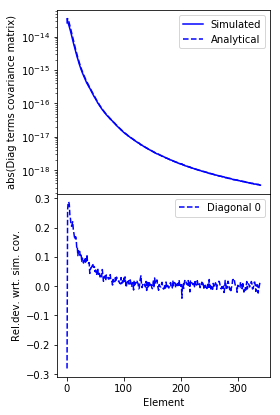

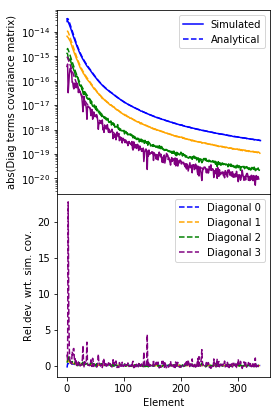

Chi2 distribution check


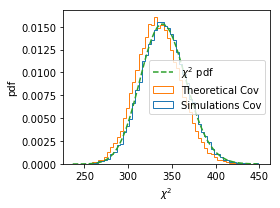

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.10345000000000004, pvalue=1.3188983180885971e-93)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004040625327597067, pvalue=0.8997039565499346)
KS between th. and chi2 distributions:  KstestResult(statistic=0.10121790823968252, pvalue=2.118473531083923e-178)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.004273684425650348, pvalue=0.8584166791013168)

Difference between analytic and sims. correlation matrix


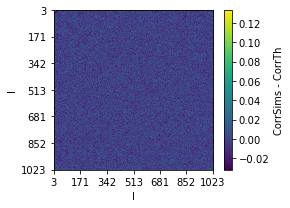

Eigenvalues vs l


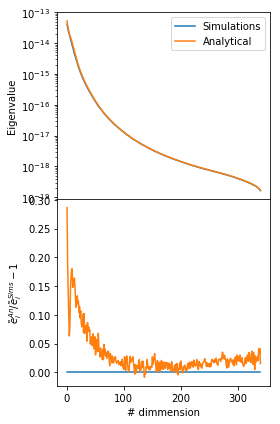

Row of cov. matrix.


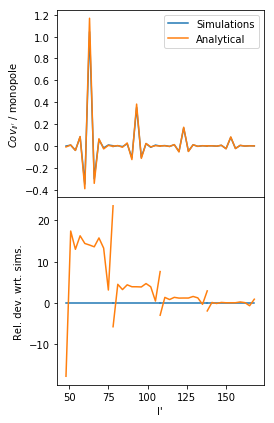

In [34]:
chi2N_E1T2E1T2, corrN_E1T2E1T2 = co.do_all_checks(lbins[:lmax], clE1T2[:, :lmax], CovSims_E1T2[:lmax, :lmax], CovTh0_E1T2[:lmax, :lmax],
                                                  modes="EEEE", foutput=foutput + '_E1T2E1T2')

# Comparing the approximations

In [35]:
foutput = fig_run_path + '_ALL'

## Diagonal & eigenvalues & row cov

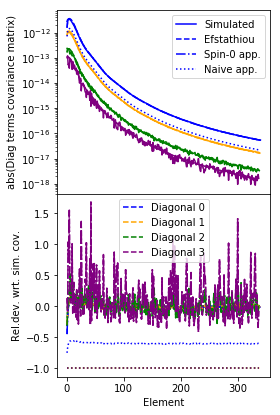

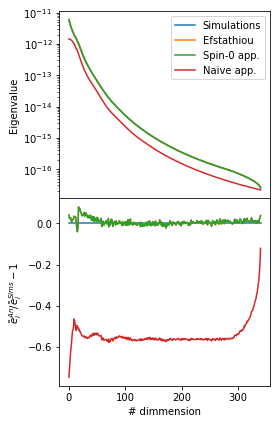

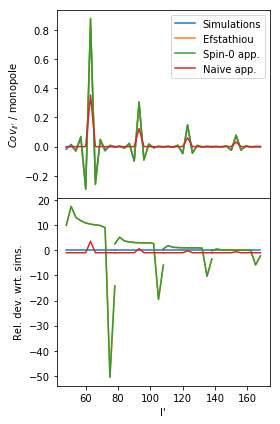

In [36]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_T1T2[:lmax,:lmax], [CovTh_T1T2[:lmax,:lmax], CovTh0_T1T2[:lmax,:lmax],
                                                                       CovThN_T1T2[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'],
                             normalization_rows=np.mean(clT1T2,axis=0)[0]**2, principal=False,
                             foutput=foutput + '_T1T2T1T2')

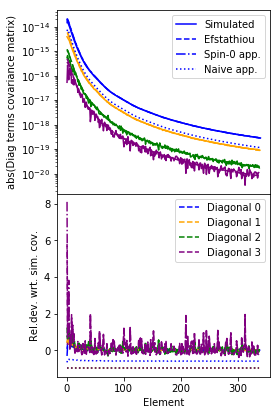

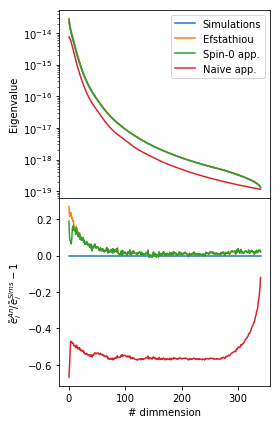

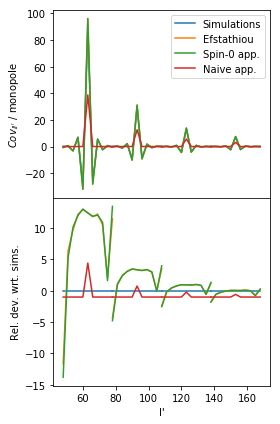

In [37]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_T1E2[:lmax,:lmax], [CovTh_T1E2[:lmax,:lmax], CovTh0_T1E2[:lmax,:lmax],
                                                                     CovThN_T1E2[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clT1E2,axis=0)[0]**2,
                             foutput=foutput + '_T1E2T1E2')

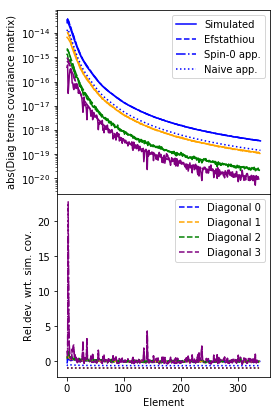

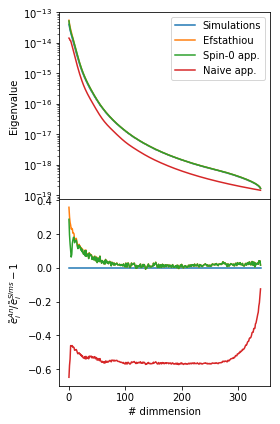

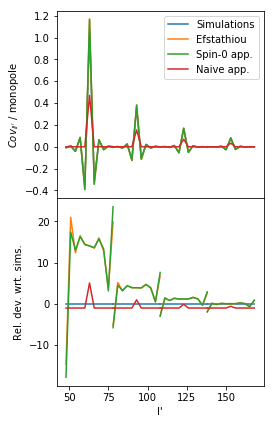

In [38]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_E1T2[:lmax,:lmax], [CovTh_E1T2[:lmax,:lmax], CovTh0_E1T2[:lmax,:lmax],
                                                                     CovThN_E1T2[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clE1T2,axis=0)[0]**2,
                             foutput=foutput + '_E1T2E1T2')

In [39]:
# co.do_check_covariance_terms(lbins[:lmax], CovSims_TB[:lmax,:lmax], [CovTh_TB[:lmax,:lmax], CovTh0_TB[:lmax,:lmax], CovThN_TB[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB, axis=0)[0]**2 )

In [40]:
# co.do_check_covariance_terms(lbins[:lmax], CovSims_EB[:lmax,:lmax], [CovTh_EB[:lmax,:lmax], CovTh0_EB[:lmax,:lmax], CovThN_EB[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB,axis=0)[0]**2)

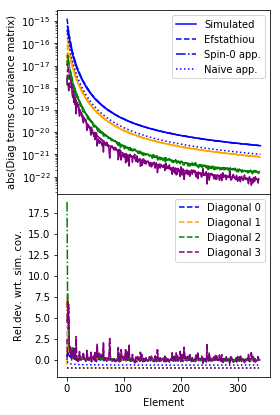

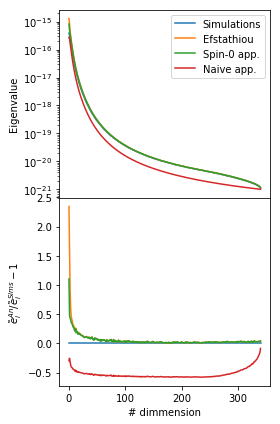

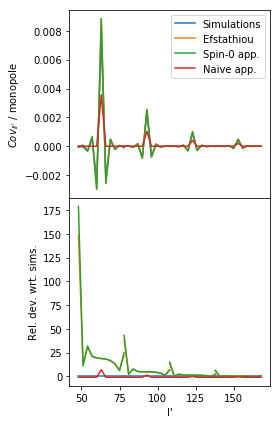

In [41]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_E1E2[:lmax,:lmax], [CovTh_E1E2[:lmax,:lmax], CovTh0_E1E2[:lmax,:lmax],
                                                                       CovThN_E1E2[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clE1E2,axis=0)[0]**2,
                             foutput=foutput + '_E1E2E1E2')

In [42]:
# co.do_check_covariance_terms(lbins[:lmax], CovSims_BB[:lmax,:lmax], [CovTh_BB[:lmax,:lmax], CovTh0_BB[:lmax,:lmax], CovThN_BB[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clBB,axis=0)[0]**2, principal=False)

## $\chi^2$

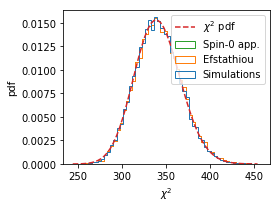

In [43]:
co.plot_chi2([chi2_T1T2T1T2[0], chi2_T1T2T1T2[1], chi20_T1T2T1T2[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_T1T2T1T2')

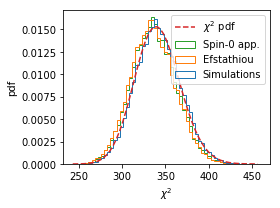

In [44]:
co.plot_chi2([chi2_T1E2T1E2[0], chi2_T1E2T1E2[1], chi20_T1E2T1E2[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_T1E2T1E2')

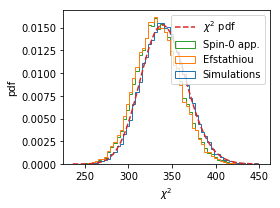

In [45]:
co.plot_chi2([chi2_E1T2E1T2[0], chi2_E1T2E1T2[1], chi20_E1T2E1T2[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
            foutput=foutput + '_E1T2E1T2')

In [46]:
# co.plot_chi2([chi2_TBTB[0], chi2_TBTB[1], chi20_TBTB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

In [47]:
# co.plot_chi2([chi2_EBEB[0], chi2_EBEB[1], chi20_EBEB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

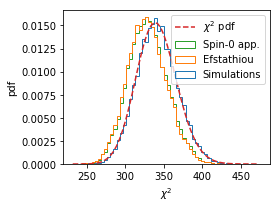

In [48]:
co.plot_chi2([chi2_E1E2E1E2[0], chi2_E1E2E1E2[1], chi20_E1E2E1E2[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_E1E2E1E2')

In [49]:
# co.plot_chi2([chi2_BBBB[0], chi2_BBBB[1], chi20_BBBB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

In [50]:
# co.plot_chi2([chi2_BBBB[0], chi20_BBBB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

# Super Cov-T1T2T1E2E1T2E2E2

In [51]:
foutput = fig_run_path + '_Efstathiou'

In [52]:
CovSims_T1T2T1E2E1T2E1E2_short = \
    np.block([[CovSims_T1T2[:lmax, :lmax], CovSims_T1T2T1E2[:lmax, :lmax], CovSims_T1T2E1T2[:lmax, :lmax], CovSims_T1T2E1E2[:lmax, :lmax]], 
            [CovSims_T1T2T1E2.T[:lmax, :lmax], CovSims_T1E2[:lmax, :lmax], CovSims_T1E2E1T2[:lmax, :lmax], CovSims_T1E2E1E2[:lmax, :lmax]], 
            [CovSims_T1T2E1T2.T[:lmax, :lmax], CovSims_T1E2E1T2.T[:lmax, :lmax], CovSims_E1T2[:lmax, :lmax], CovSims_E1T2E1E2[:lmax, :lmax]],
            [CovSims_T1T2E1E2.T[:lmax, :lmax], CovSims_T1E2E1E2.T[:lmax, :lmax], CovSims_E1T2E1E2.T[:lmax, :lmax], CovSims_E1E2[:lmax, :lmax]] ])

CovTh_T1T2T1E2E1T2E1E2_short = \
    np.block([[CovTh_T1T2[:lmax, :lmax], CovTh_T1T2T1E2[:lmax, :lmax], CovTh_T1T2E1T2[:lmax, :lmax], CovTh_T1T2E1E2[:lmax, :lmax]], 
            [CovTh_T1T2T1E2.T[:lmax, :lmax], CovTh_T1E2[:lmax, :lmax], CovTh_T1E2E1T2[:lmax, :lmax], CovTh_T1E2E1E2[:lmax, :lmax]], 
            [CovTh_T1T2E1T2.T[:lmax, :lmax], CovTh_T1E2E1T2.T[:lmax, :lmax], CovTh_E1T2[:lmax, :lmax], CovTh_E1T2E1E2[:lmax, :lmax]],
            [CovTh_T1T2E1E2.T[:lmax, :lmax], CovTh_T1E2E1E2.T[:lmax, :lmax], CovTh_E1T2E1E2.T[:lmax, :lmax], CovTh_E1E2[:lmax, :lmax]] ])

clT1T2T1E2E1T2E1E2 = np.concatenate([clT1T2[:, :lmax], clT1E2[:, :lmax], clE1T2[:, :lmax], clE1E2[:, :lmax]], axis=1)
lbinsT1T2T1E2E1T2E1E2 = np.concatenate([lbins[:lmax]]*4)

Checks for T1T2T1E2E1T2E1E2
Diagonal covariance matrix


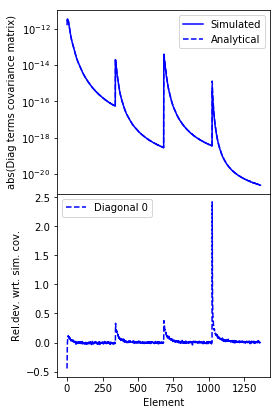

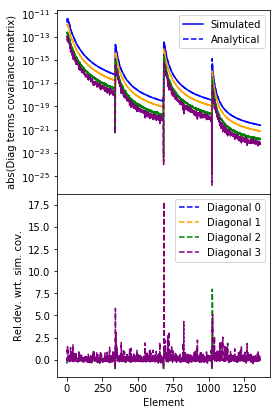

Chi2 distribution check


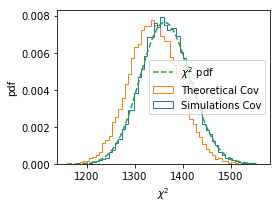

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.1844, pvalue=1.7211877684819245e-296)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.007934219727650405, pvalue=0.16114502284420784)
KS between th. and chi2 distributions:  KstestResult(statistic=0.18493322694234327, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.004772021456155906, pvalue=0.7525651045430783)

Difference between analytic and sims. correlation matrix


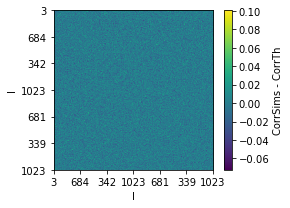

Eigenvalues vs l


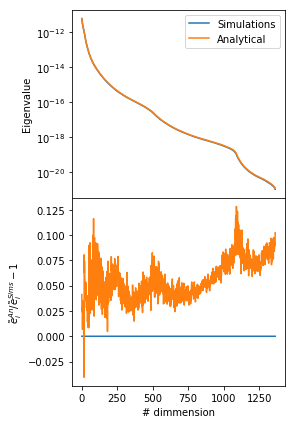

In [53]:
chi2_T1T2T1E2E1T2E1E2, corr_T1T2T1E2E1T2E1E2 = co.do_all_checks(lbinsT1T2T1E2E1T2E1E2, clT1T2T1E2E1T2E1E2,
                                                                CovSims_T1T2T1E2E1T2E1E2_short, CovTh_T1T2T1E2E1T2E1E2_short,
                                                                modes="T1T2T1E2E1T2E1E2", row_cov=False,
                                                               foutput=foutput + '_T1T2T1E2E1T2E1E2')